In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Replace these paths with the actual paths to your dataset folders
data_dir = '/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/lung_colon_image_set'
filepaths = []
image_data = []
labels = []


folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path , file)
            try:
              # Open the image using PIL (or you can use OpenCV) within a 'with' statement
              with Image.open(fpath) as image:
                if image is not None:
                  # Resize images
                  im = image.resize((120,120), Image.LANCZOS)
                  # Append image and label to respective lists
                  image_data.append(np.array(im))
                else:
                  print(f"Error opening image '{fpath}': NoneType object returned")
            except Exception as e:
              print(f"Error opening image '{fpath}': {e}")
            # Assign the label of the images according to the folder they belongs to.
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

tr_labels = np.array(labels)
image_matrix = np.array([np.array(img) for img in image_data])

np.save("/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/data120.npy",image_matrix)
np.save("/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/labels120.npy",tr_labels)


Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

#Call data from directory

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_dir = "/content/drive/MyDrive/Deep_Learning_Spring24/Assignment/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma' ...
 'Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initiating encoder
le = LabelEncoder()

# Convert categorical labels to numerical labels
labels_num = le.fit_transform(labels)


# Convert numerical labels to one-hot encoded format
labels_oh = to_categorical(labels_num)

print(labels_oh)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


## Visualizing Sample Images

(25000, 120, 120, 3)


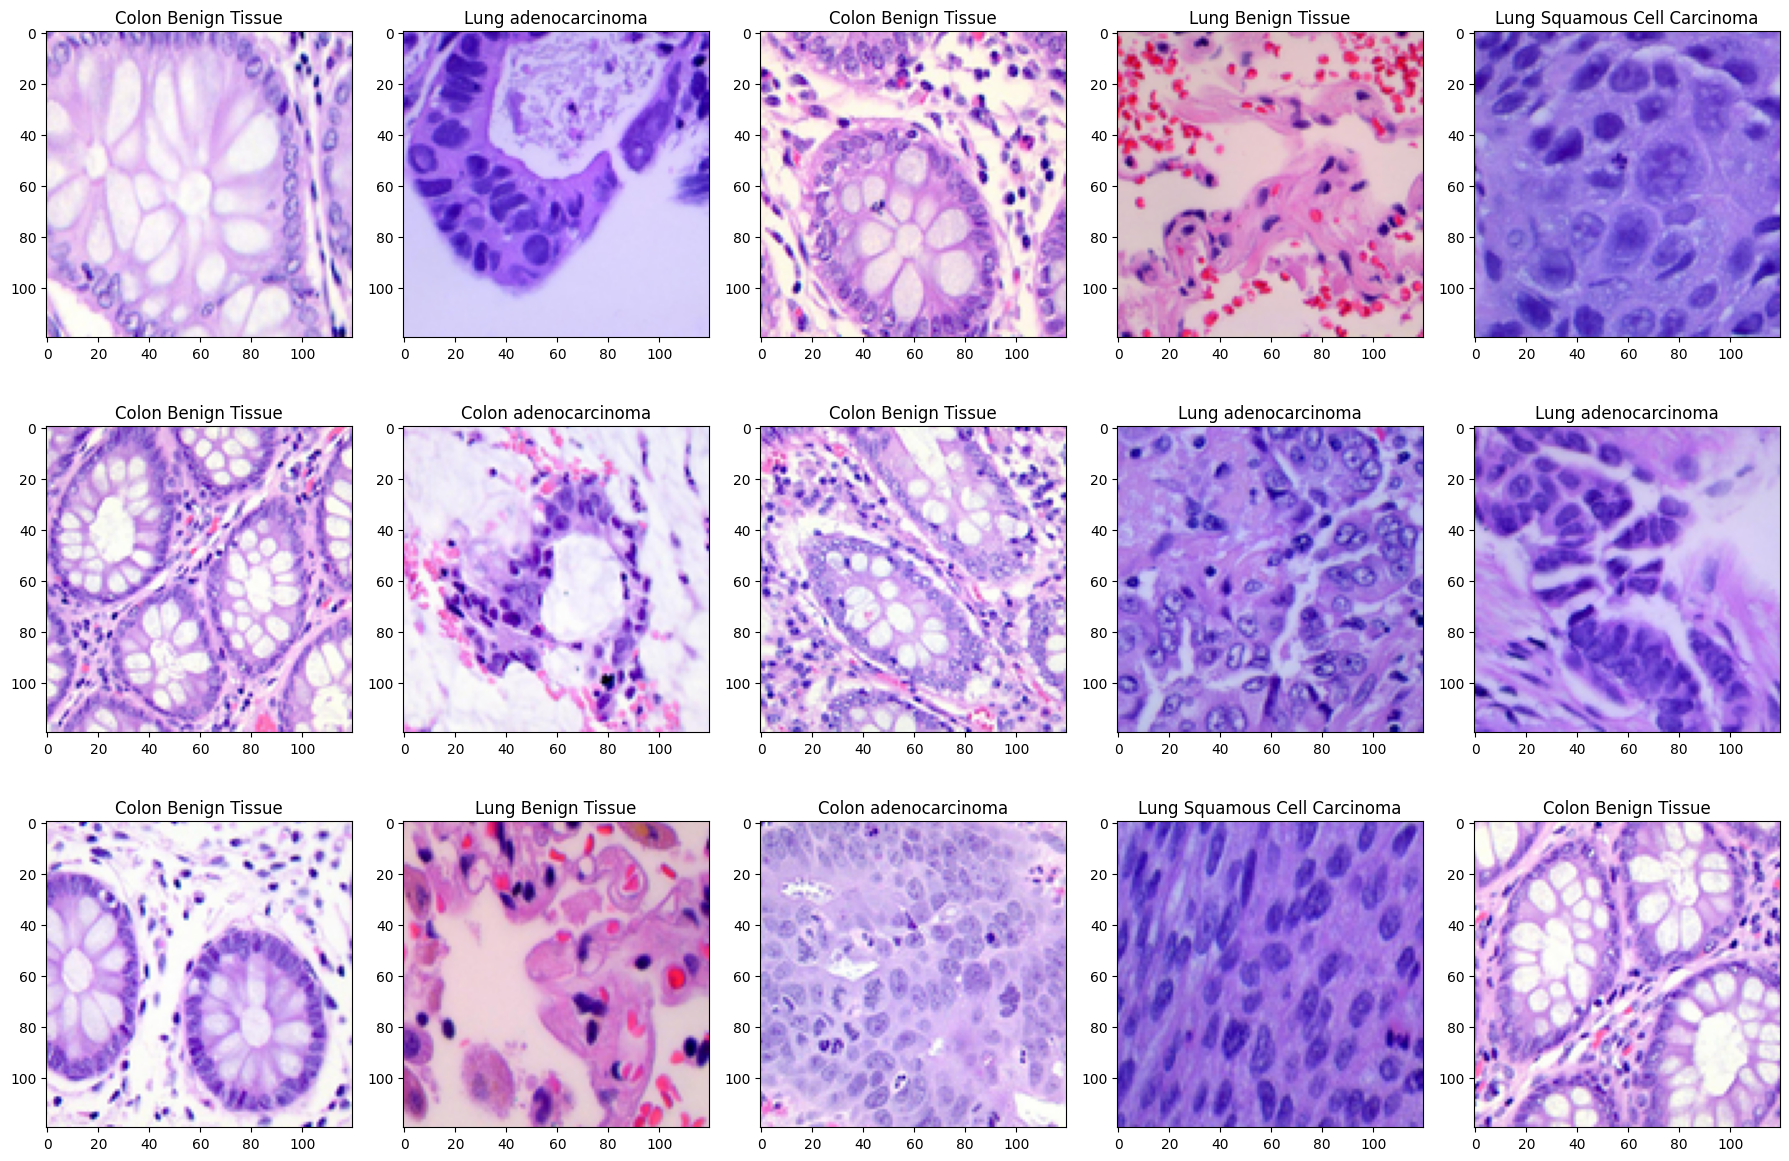

In [ ]:
print(data.shape) # by doing this, we understand each dimension (n of images, height, length, n of channels (3 since RGB)
num_images = data.shape[0]

# Generate random indices to select random images
random_idx = np.random.choice(num_images, 15, replace=False) # select 15 random images

# Creating a bigger plot since titles overlap even after tight_layout
plt.figure(figsize=(18, 12))

# Plot the images
for i, idx in enumerate(random_idx):
    plt.subplot(3, 5, i + 1)
    plt.imshow(data[idx])
    plt.title(labels[idx])

# Implement tight_layout so that everything is readable
plt.tight_layout()
plt.show()


## Visualizing Class Distribution

['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma'] [5000 5000 5000 5000 5000]


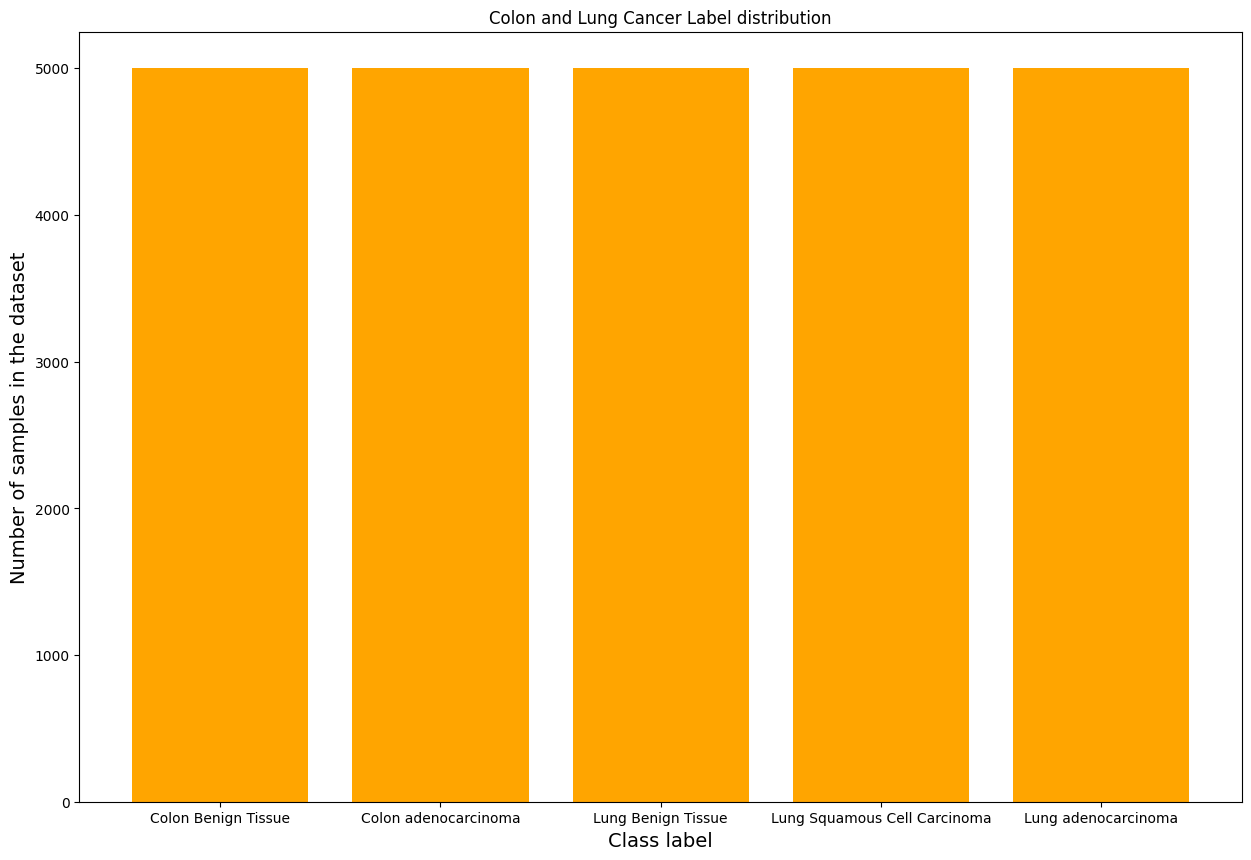

In [ ]:
# Create the height of the bars by counting unique instances
unique_labels, label_counts = np.unique(labels, return_counts=True)
print(unique_labels, label_counts)

# Plot the bar plot (again, initiated subplot to better readability)
plt.subplots(figsize = (15,10))
plt.bar(unique_labels, label_counts, color = 'orange')
plt.ylabel("Number of samples in the dataset", fontsize = 14)
plt.xlabel("Class label", fontsize = 14)
plt.title("Colon and Lung Cancer Label distribution")
plt.tight_layout
plt.show()


##Train-Test-Val Split

In [ ]:
from sklearn.model_selection import train_test_split

# First divide the data to trainval and test
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels_oh, test_size = 0.2,
                                                         stratify=labels_oh, random_state = 42)

# Then divide the data to train and test
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25,
                                                  stratify=y_trainval, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape)
print(data.shape)

(15000, 120, 120, 3) (5000, 120, 120, 3) (5000, 120, 120, 3)
(25000, 120, 120, 3)


# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [ ]:
## LOSS-ACC GRAPHS FUNCTION

def loss_acc_graphs(history, model_name):
  # Plotting the loss
  best_epoch_loss = np.argmin(history.history['val_loss'])  # find the epoch with the lowest loss
  best_val_loss = history.history['val_loss'][best_epoch_loss]

  # Initiating the subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))

  # Subplot for loss
  axs[0].set_title(f'{model_name} Training and Validation Loss')
  axs[0].plot(history.history['loss'], color='red')
  axs[0].plot(history.history['val_loss'], color='green')
  axs[0].scatter(best_epoch_loss, best_val_loss, color='blue')
  axs[0].legend(['Training', 'Validation', 'Best Epoch'])
  axs[0].set_xlabel("Epochs")
  axs[0].set_xticks(range(2,11,2))
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)

  # Plotting the accuracy
  best_epoch_acc = np.argmax(history.history['val_accuracy'])  # find the epoch with the highest accuracy
  best_val_acc = history.history['val_accuracy'][best_epoch_acc]

  # Subplot for accuracy
  axs[1].set_title(f'{model_name} Training and Validation Accuracy')
  axs[1].plot(history.history['accuracy'], color='red')
  axs[1].plot(history.history['val_accuracy'], color='green')
  axs[1].scatter(best_epoch_acc, best_val_acc, color='blue')
  axs[1].legend(['Training', 'Validation', 'Best Epoch'])
  axs[1].set_xlabel("Epochs")
  axs[1].set_xticks(range(2,11,2))
  axs[1].set_ylabel("Accuracy")
  axs[1].grid(True)

  # Tight layout and presenting the plot
  plt.tight_layout()
  plt.show()


In [ ]:
#Confusion matrix and classification report function

# The Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def conf_mat_classif_report(model):
  # Plotting the subplots
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  # Get predictions
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  # Apply one-hot encoding to predictions
  y_pred_test_int = np.argmax(y_pred_test, axis=1)
  y_pred_val_int = np.argmax(y_pred_val, axis=1)

  # Apply one-hot to y_test and y_val
  y_test_int = np.argmax(y_test, axis=1)
  y_val_int = np.argmax(y_val, axis=1)

  # Conf Matrix for the test set
  conf_mat_test = confusion_matrix(y_test_int, y_pred_test_int)

  ax = plt.subplot(1, 2, 1)
  sns.heatmap(conf_mat_test, annot=True, fmt='d', cmap='rocket',
              yticklabels=unique_labels, ax=ax)
  ax.set_xlabel("Predicted Label")
  ax.set_ylabel("True Label")

  # Conf Matrix for the validation set
  conf_mat_val = confusion_matrix(y_val_int, y_pred_val_int)

  ax = plt.subplot(1,2,2)
  sns.heatmap(conf_mat_val, annot=True, fmt='d', cmap='magma',
              yticklabels=unique_labels, ax=ax)
  ax.set_xlabel("Predicted Label")
  ax.set_ylabel("True Label")

  plt.tight_layout()
  plt.show()

  # Classification report
  from sklearn.metrics import classification_report

  # CR for test set
  test_report = classification_report(y_test_int, y_pred_test_int)
  print(test_report)
  # CR for validation set
  val_report = classification_report(y_val_int, y_pred_val_int)
  print(val_report)

In [ ]:
#ROC curves function

from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from itertools import cycle

def ROC_curves2(model, X_val, y_val, title):
  y_score = model.predict(X_val)

  # Store the fpr, tpr, and roc_auc
  fpr, tpr, roc_auc = dict(), dict(), dict()

  # Compute micro-average ROC curve and area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  fpr["macro"], tpr["macro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Initialize plot
  fig, ax = plt.subplots(figsize=(6, 6))

  # Perform plotting
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
      color="darkred",
      linestyle=":",
      linewidth=4,
  )

  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
      color="mediumblue",
      linestyle=":",
      linewidth=4,
  )

  n_classes = y_val.shape[1]
  colors = cycle(["DarkCyan", "DarkGoldenRod", "DarkMagenta", "DarkOliveGreen", "DarkRed"])

  # Iterate over all classes
  for class_id, color in zip(range(n_classes), colors):
      RocCurveDisplay.from_predictions(
          y_val[:, class_id],
          y_score[:, class_id],
          name=f"ROC curve for {np.unique(labels)[class_id]}",
          color=color,
          ax=ax,
      )

  _ = ax.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=title,
  )
  return

# Baseline Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', input_shape = X_train.shape[1:]))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(5, activation='softmax')) # outpiut is 5 since there are 5 classes to predict
model.summary()

# Compile the model
model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy', # because we are solving a classification problem
              metrics = ['accuracy'])

#Fit the model
history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_val, y_val))

#Get test and accuracy loss
test_loss, acc_loss = model.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

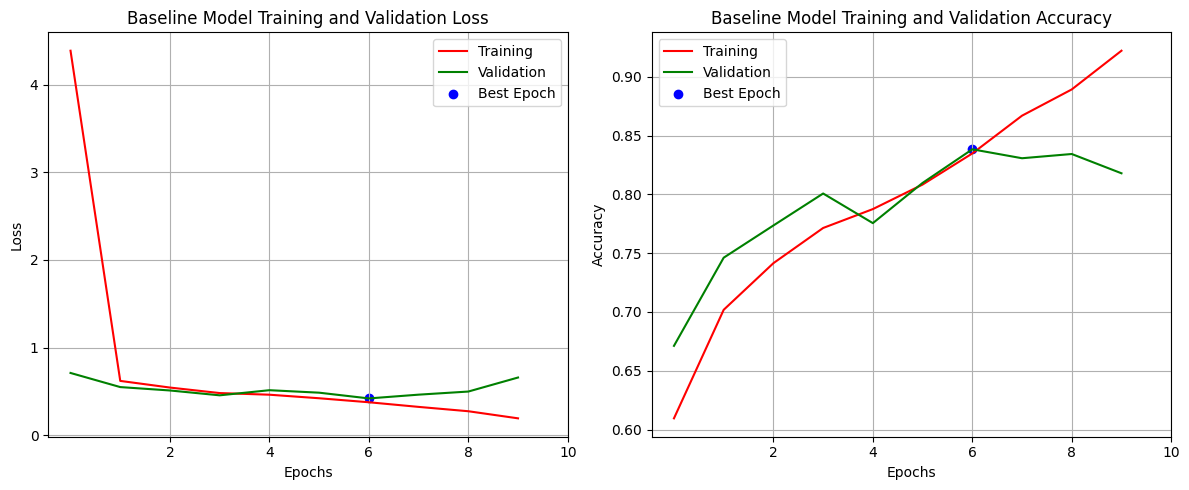

In [ ]:
## Loss-acc graphs for the baseline
bs_graphs = loss_acc_graphs(history, "Baseline Model")
bs_graphs

157/157 [==============================] - 1s 7ms/step


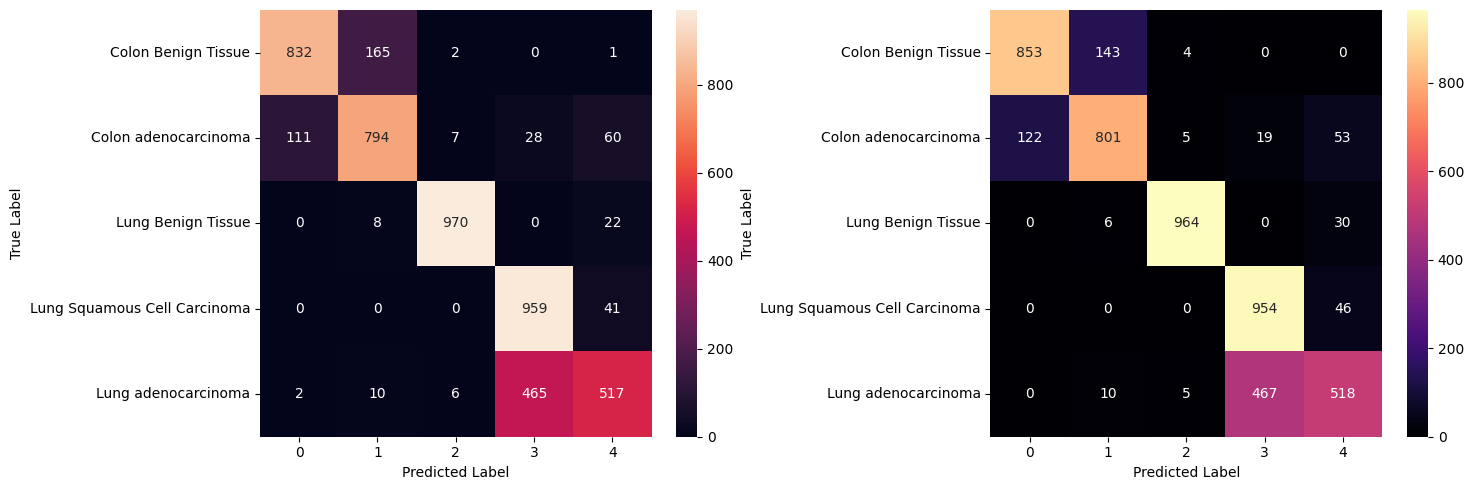

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1000
           1       0.81      0.79      0.80      1000
           2       0.98      0.97      0.98      1000
           3       0.66      0.96      0.78      1000
           4       0.81      0.52      0.63      1000

    accuracy                           0.81      5000
   macro avg       0.83      0.81      0.81      5000
weighted avg       0.83      0.81      0.81      5000

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1000
           1       0.83      0.80      0.82      1000
           2       0.99      0.96      0.97      1000
           3       0.66      0.95      0.78      1000
           4       0.80      0.52      0.63      1000

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.81      5000
weighted avg       0.83      0.82      0.81      5000



In [ ]:
# Confusion matrix and classification report for the baseline
bs_cm = conf_mat_classif_report(model)
bs_cm

157/157 [==============================] - 1s 7ms/step


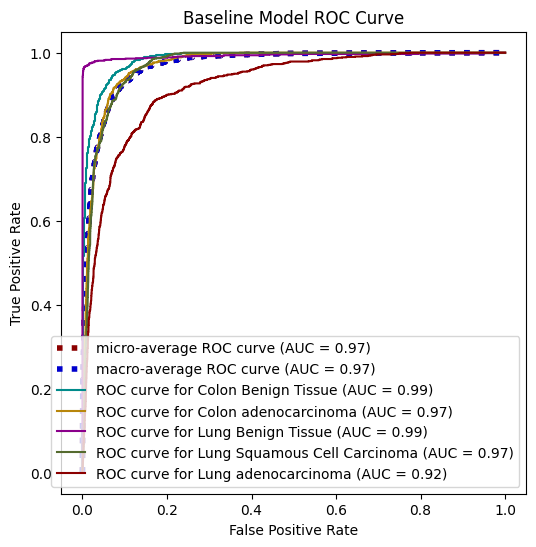

In [ ]:
# ROC curve for baseline
bs_roc = ROC_curves2(model, X_val, y_val, "Baseline Model ROC Curve")
bs_roc

# Enhanced Model

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

# Create a sequential model
model2 = Sequential()

# This time, introduce regularization (apply to all convolutional and dense layers)
regularizer= regularizer=regularizers.l2(0.001)

# Introduce dropout
dropout_rate = 0.2

# Try different learning rate
optimizer = Adam(learning_rate=0.001)

# Add convolutional and pooling layers
model2.add(layers.Conv2D(128, (3,3), activation = 'relu', strides=(2, 2), padding = 'same', input_shape = X_train.shape[1:]))
model2.add(layers.Dropout(dropout_rate))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), activation = 'relu', strides=(2, 2), padding = 'same')) #added stride to all conv layers
model2.add(layers.Dropout(dropout_rate))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), activation = 'relu', strides=(2, 2), padding = 'same')) # 32 conv layer
model2.add(layers.Dropout(dropout_rate))
model2.add(layers.AveragePooling2D((2,2))) # last layer changed to avg pooling instead
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizer)) # adding more layers
model2.add(layers.Dropout(dropout_rate))
model2.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizer)) # 64 dense layer added
model2.add(layers.Dropout(dropout_rate))
model2.add(layers.Dense(32, activation = 'relu', kernel_regularizer=regularizer)) # 32 dense layer added
model2.add(layers.Dropout(dropout_rate))
model2.add(layers.Dense(32, activation = 'relu', kernel_regularizer=regularizer))
model2.add(layers.Dropout(dropout_rate))
model2.add(layers.Dense(5, activation='softmax')) # output is 5 since there are 5 classes to predict
model2.summary()
# Compile the model
model2.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy', # because we are solving a classification problem
              metrics = ['accuracy'])

#Fit the model
history2 = model2.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_val, y_val))

#Get test and accuracy loss
test_loss2, acc_loss2 = model2.evaluate(X_test, y_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       3584      
                                                                 
 dropout_22 (Dropout)        (None, 60, 60, 128)       0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 15, 15, 64)        73792     
                                                                 
 dropout_23 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                 

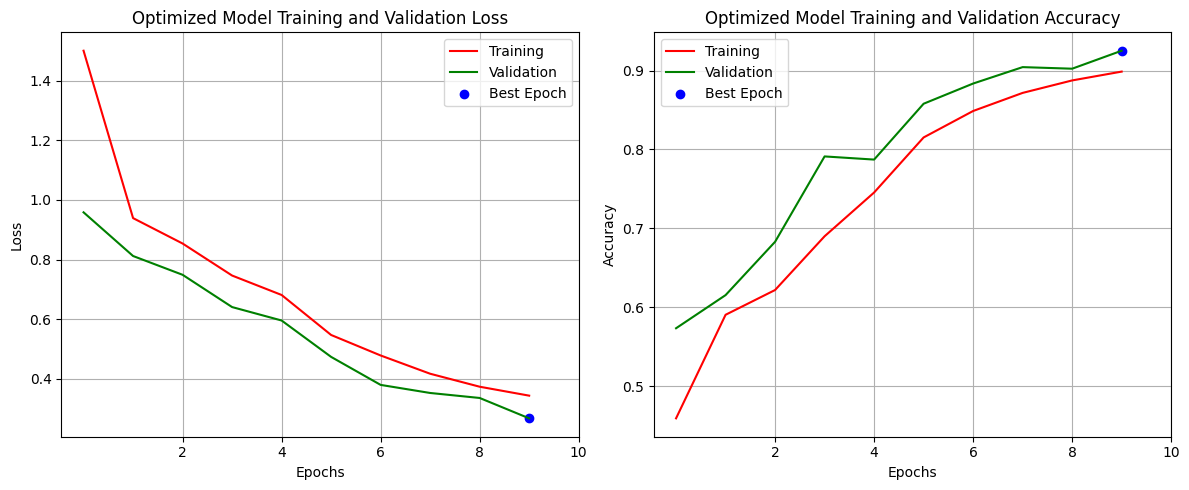

In [ ]:
## Loss-acc graphs for the optimized model
opt_graphs = loss_acc_graphs(history2, "Optimized Model")

157/157 [==============================] - 1s 7ms/step


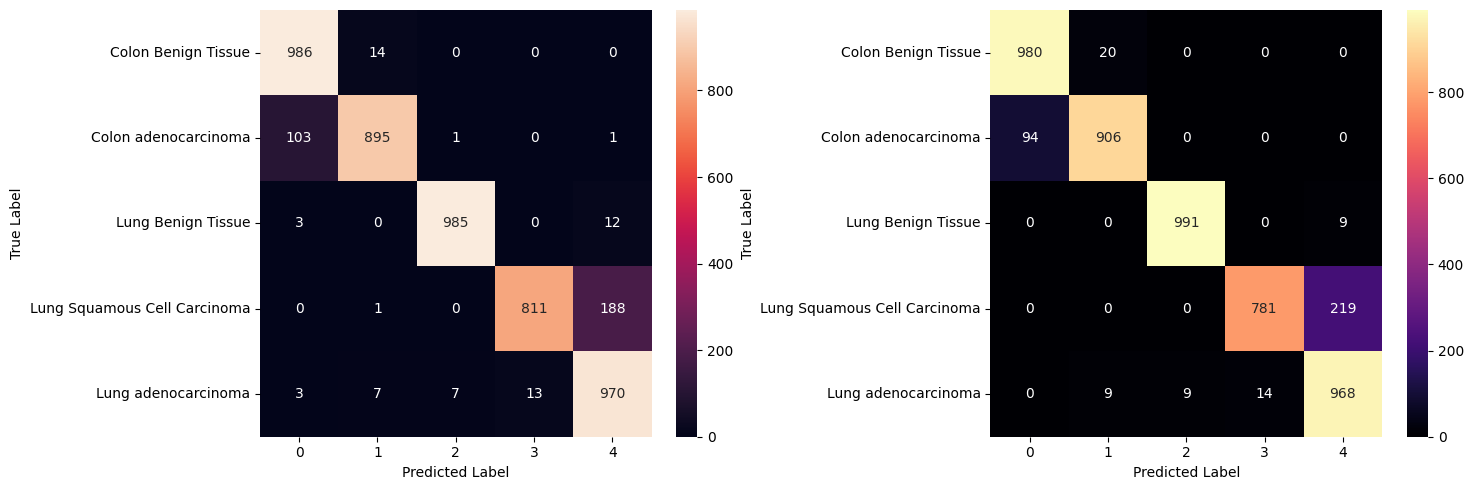

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1000
           1       0.98      0.90      0.93      1000
           2       0.99      0.98      0.99      1000
           3       0.98      0.81      0.89      1000
           4       0.83      0.97      0.89      1000

    accuracy                           0.93      5000
   macro avg       0.94      0.93      0.93      5000
weighted avg       0.94      0.93      0.93      5000

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1000
           1       0.97      0.91      0.94      1000
           2       0.99      0.99      0.99      1000
           3       0.98      0.78      0.87      1000
           4       0.81      0.97      0.88      1000

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.92      5000
weighted avg       0.93      0.93      0.92      5000



In [ ]:
# Confusion matrix and classification report for the optimized model
opt_cm = conf_mat_classif_report(model2)
opt_cm

157/157 [==============================] - 1s 3ms/step


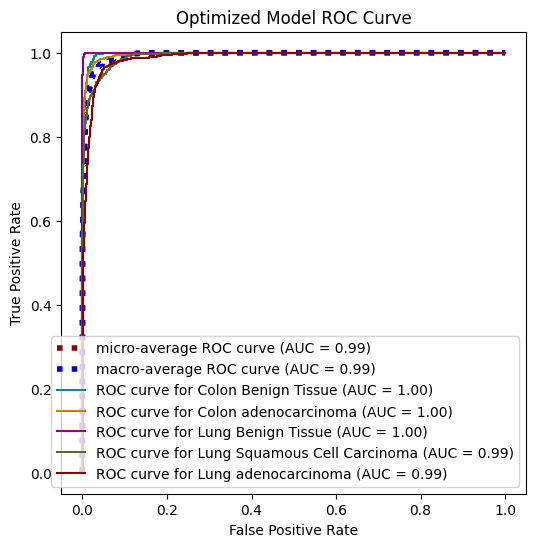

In [ ]:
# ROC curve for the optimized model
opt_roc = ROC_curves2(model2, X_val, y_val, "Optimized Model ROC Curve")
opt_roc

# Transfer Learning Model


In [ ]:
# Transfer Learning Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

# Initiate model without the top layer
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

optimizer = Adam(learning_rate= 0.001)
dropout_rate = 0.2
regularizer= regularizer=regularizers.l2(0.001)

# Freeze layers until the fully connected one
for layer in vgg_model.layers:
    layer.trainable = False

# Adding the fully connected layer separately
model3 = Sequential()
model3.add(vgg_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizer)) # adding more layers
model3.add(layers.Dropout(dropout_rate))
model3.add(layers.Dense(64, activation = 'relu', kernel_regularizer=regularizer)) # 64 dense layer added
model3.add(layers.Dropout(dropout_rate))
model3.add(layers.Dense(32, activation = 'relu', kernel_regularizer=regularizer)) # 32 dense layer added
model3.add(layers.Dropout(dropout_rate))
model3.add(layers.Dense(32, activation = 'relu', kernel_regularizer=regularizer))
model3.add(layers.Dropout(dropout_rate))
model3.add(layers.Dense(5, activation='softmax'))
model3.summary()

# Compile the model
model3.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy', # because we are solving a classification problem
              metrics = ['accuracy'])

#Fit the model
history3 = model3.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_val, y_val))

#Get test and accuracy loss
test_loss3, acc_loss3 = model3.evaluate(X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_13 (Dense)            (None, 128)               589952    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)               

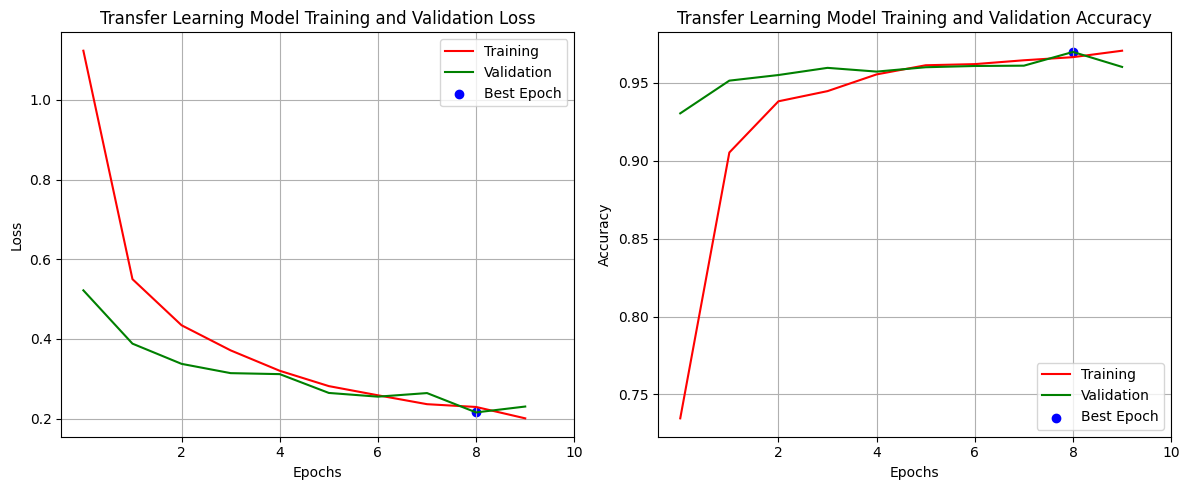

In [ ]:
## Loss-acc graphs for transfer learning model

tl_graphs = loss_acc_graphs(history3, "Transfer Learning Model")
tl_graphs

157/157 [==============================] - 6s 36ms/step


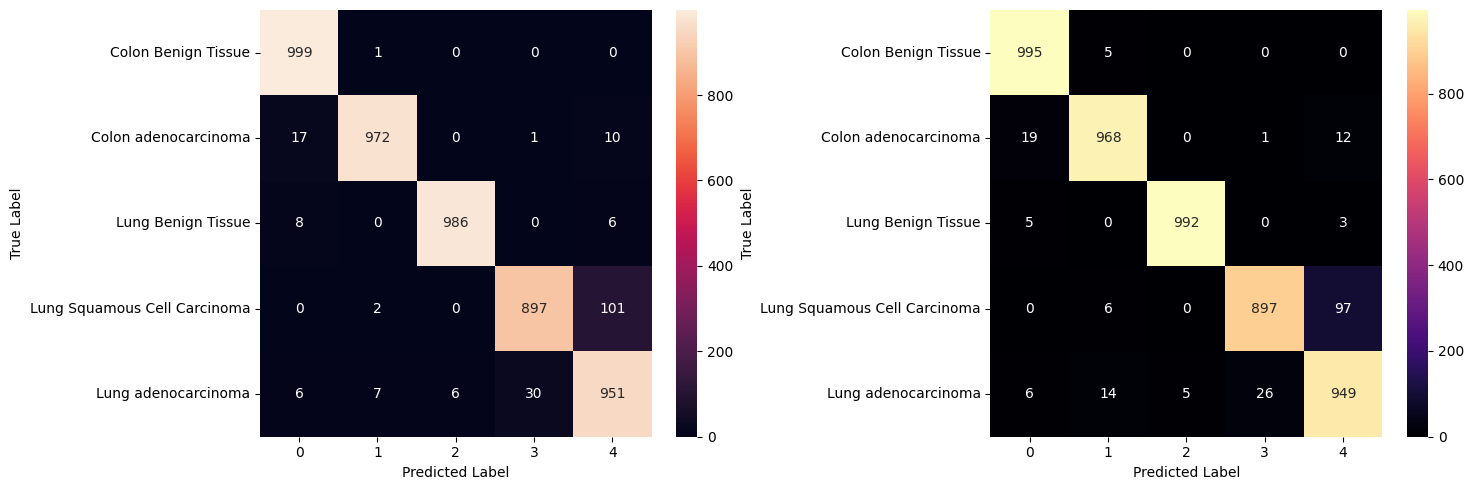

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1000
           1       0.99      0.97      0.98      1000
           2       0.99      0.99      0.99      1000
           3       0.97      0.90      0.93      1000
           4       0.89      0.95      0.92      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.97      0.97      0.97      1000
           2       0.99      0.99      0.99      1000
           3       0.97      0.90      0.93      1000
           4       0.89      0.95      0.92      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [ ]:
#Confusion matrix and classification report for transfer learning

tl_cm = conf_mat_classif_report(model3)
tl_cm

157/157 [==============================] - 6s 35ms/step


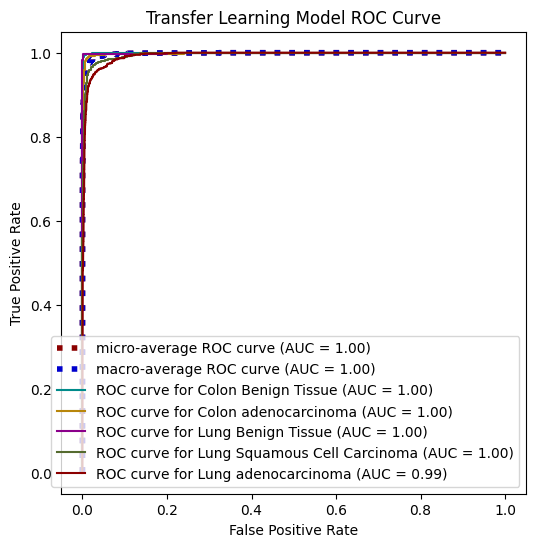

In [ ]:
# ROC curve for transfer learning model
tl_roc = ROC_curves2(model3, X_val, y_val, "Transfer Learning Model ROC Curve")
tl_roc